# Introduction to Model Optimization

**Module 03 | Notebook 1 of 5**

This notebook introduces the key techniques for making LLMs faster, smaller, and cheaper to deploy.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand why optimization is essential for production
2. Compare distillation, pruning, and quantization techniques
3. Choose the right optimization strategy for your use case
4. Calculate cost-benefit trade-offs

### Prerequisites
- Basic familiarity with PyTorch and Hugging Face Transformers
- Understanding of what large language models are

---

In [1]:
%%capture
# Install necessary libraries:
# transformers: for using pre-trained models
# torch: the underlying deep learning framework
# matplotlib & pandas: for visualization and data handling
!pip install transformers torch matplotlib pandas

In [2]:
import torch
from transformers import AutoModel, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## Why Optimize LLMs?

### The Production Challenge

```
┌─────────────────────────────────────────────────────────────────┐
│                     The LLM Trilemma                            │
│                                                                 │
│                        ACCURACY                                 │
│                           ▲                                     │
│                          / \                                    │
│                         /   \                                   │
│                        /     \                                  │
│              SPEED ◄──────────► COST                            │
│                                                                 │
│   Large models: High accuracy, slow, expensive                  │
│   Small models: Fast, cheap, but less accurate                  │
│                                                                 │
│   🎯 Goal: Get the best of all three with optimization!        │
└─────────────────────────────────────────────────────────────────┘
```

### Real-World Constraints

| Constraint | Impact |
|------------|--------|
| **Latency** | Users expect <100ms response times |
| **Memory** | Edge devices have limited RAM |
| **Cost** | GPU compute is expensive at scale |
| **Energy** | Large models consume significant power |
| **Throughput** | Need to serve thousands of requests/sec |

### ⚠️ When NOT to Optimize

> **Warning**: Model optimization is not appropriate for all applications. Consider carefully before applying these techniques in the following domains:
>
> - **Medical Diagnosis**: Even small accuracy drops can lead to missed diagnoses or incorrect treatments with life-threatening consequences.
> - **Financial Predictions**: Trading systems and risk models require maximum precision; a 1% accuracy loss could mean millions in losses.
> - **Legal Analysis**: Court decisions and contract reviews demand full precision to avoid liability issues.
> - **Safety-Critical Systems**: Autonomous vehicles, aviation, and industrial control systems where errors can cause physical harm.
>
> In these high-stakes domains, the compute cost savings from optimization rarely justify the increased risk from reduced accuracy. **Always prioritize full precision models when human safety or significant financial exposure is involved.**

In [3]:
# Compare model sizes
models = [
    ("distilbert-base-uncased", "DistilBERT"),
    ("bert-base-uncased", "BERT-base"),
    ("bert-large-uncased", "BERT-large"),
]

data = []
for model_name, label in models:
    print(f"Loading {label}...")
    model = AutoModel.from_pretrained(model_name)
    params = sum(p.numel() for p in model.parameters())
    # Calculate size in MB: parameters * 4 bytes (since FP32 uses 4 bytes per number) / (1024*1024 to get MB)
    size_mb = params * 4 / (1024**2) 
    data.append({"Model": label, "Parameters (M)": params/1e6, "Size (MB)": size_mb})
    del model

df = pd.DataFrame(data)
print("\nModel Comparison:")
print(df.to_string(index=False))

Loading DistilBERT...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading BERT-base...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading BERT-large...


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]


Model Comparison:
     Model  Parameters (M)   Size (MB)
DistilBERT       66.362880  253.154297
 BERT-base      109.482240  417.641602
BERT-large      335.141888 1278.464844


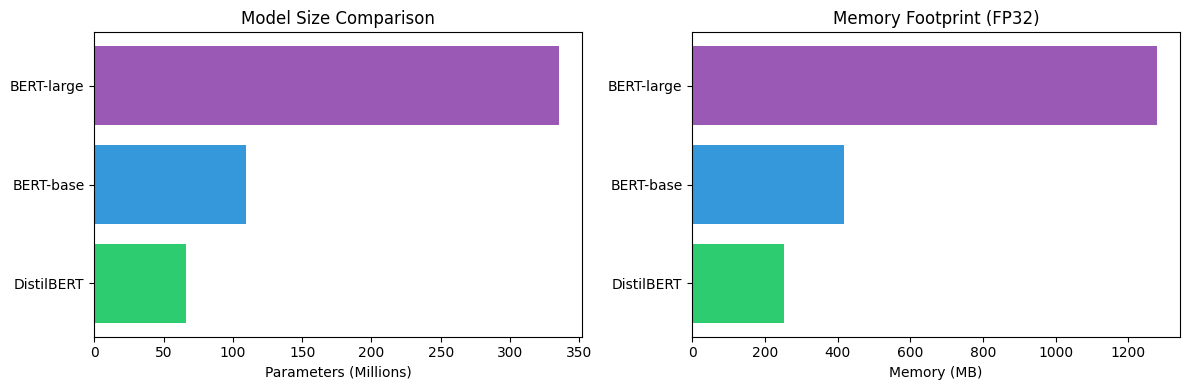


DistilBERT is 1.6x smaller than BERT-base
That's a 39% reduction!


In [4]:
# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2ecc71', '#3498db', '#9b59b6']

axes[0].barh(df['Model'], df['Parameters (M)'], color=colors)
axes[0].set_xlabel('Parameters (Millions)')
axes[0].set_title('Model Size Comparison')

axes[1].barh(df['Model'], df['Size (MB)'], color=colors)
axes[1].set_xlabel('Memory (MB)')
axes[1].set_title('Memory Footprint (FP32)')

plt.tight_layout()
plt.show()

# Calculate savings
bert_params = df[df['Model']=='BERT-base']['Parameters (M)'].values[0]
distil_params = df[df['Model']=='DistilBERT']['Parameters (M)'].values[0]
print(f"\nDistilBERT is {bert_params/distil_params:.1f}x smaller than BERT-base")
print(f"That's a {(1-distil_params/bert_params)*100:.0f}% reduction!")

---

## The Three Pillars of Optimization

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    Model Optimization Techniques                        │
├───────────────────────┬───────────────────────┬─────────────────────────┤
│     DISTILLATION      │       PRUNING         │      QUANTIZATION       │
├───────────────────────┼───────────────────────┼─────────────────────────┤
│                       │                       │                         │
│  Teacher → Student    │  Remove connections   │  Reduce precision       │
│                       │                       │                         │
│  ┌───────────────┐    │  ●●●●●●  →  ●○●○●●   │  32-bit → 8-bit         │
│  │ Large Model   │    │  ●●●●●●     ●●○○●●   │                         │
│  │   (Teacher)   │    │  ●●●●●●     ○●●●○●   │  1.234567890            │
│  └───────┬───────┘    │                       │       ↓                 │
│          │ teaches    │                       │    1.23                 │
│          ▼            │                       │                         │
│  ┌───────────────┐    │                       │                         │
│  │ Small Model   │    │                       │                         │
│  │   (Student)   │    │                       │                         │
│  └───────────────┘    │                       │                         │
│                       │                       │                         │
├───────────────────────┼───────────────────────┼─────────────────────────┤
│ Size: 2-10x smaller   │ Size: 50-90% sparse   │ Size: 2-4x smaller      │
│ Speed: 2-3x faster    │ Speed: 1.5-3x faster  │ Speed: 2-4x faster      │
│ Accuracy: 95-99%      │ Accuracy: 90-99%      │ Accuracy: 95-99%        │
└───────────────────────┴───────────────────────┴─────────────────────────┘
```

### Technique Comparison

| Technique | How It Works | Pros | Cons |
|-----------|--------------|------|------|
| **Distillation** | Train small model to mimic large model | Most accuracy retention | Requires training |
| **Pruning** | Remove unimportant weights | No retraining needed | Sparse operations support varies |
| **Quantization** | Reduce numerical precision | Easy to apply, big speedups | Some accuracy loss |

### 🔧 Under the Hood: Dynamic Quantization

In this demo, we use **Dynamic Quantization**. Here is what happens under the hood:

1. **Weights (Static)**: The weights of the model are converted from 32-bit floating point numbers (FP32) to 8-bit integers (INT8) **ahead of time**. Since 8 bits is 1/4th of 32 bits, this immediately reduces the model file size by approximately 4x.
2. **Activations (Dynamic)**: The 'activations' (the data passing through the layers) are still kept in FP32 format between layers. However, just before a matrix multiplication, they are quantized to INT8 **on-the-fly** (dynamically).
3. **Computation**: The heavy matrix multiplication occurs using efficient INT8 arithmetic. The result is then converted back to FP32.

**Why Dynamic?** It's called 'dynamic' because the quantization of the inputs happens at runtime. This is the easiest form to apply because it requires **no retraining** and no representative dataset for calibration. It works particularly well for LSTM and Transformer-based models (like BERT).


> **💡 Calibration Note**: While dynamic quantization doesn't require calibration data, more advanced techniques like *static quantization* and *quantization-aware training (QAT)* use representative sample inputs to determine optimal quantization ranges. In practice, you'd provide ~100-1000 sample inputs to calibrate the quantization parameters for best accuracy retention.

In [5]:
from transformers import AutoTokenizer

# Load a small model for demo
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_fp32 = AutoModelForSequenceClassification.from_pretrained(model_name)

# Model size in FP32
params = sum(p.numel() for p in model_fp32.parameters())
fp32_size = params * 4  # 4 bytes per float32

print(f"Model: {model_name}")
print(f"Parameters: {params:,}")
print(f"FP32 Size: {fp32_size / 1024**2:.1f} MB")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model: distilbert-base-uncased-finetuned-sst-2-english
Parameters: 66,955,010
FP32 Size: 255.4 MB


In [6]:
# Apply dynamic quantization (INT8)
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32, 
    {torch.nn.Linear},  # Quantize Linear layers
    dtype=torch.qint8
)

print("\n✅ Dynamic quantization applied!")


✅ Dynamic quantization applied!


In [7]:
# Compare inference speed
test_text = "This movie was absolutely fantastic! I loved every minute of it."
inputs = tokenizer(test_text, return_tensors="pt")

# Warmup
with torch.no_grad():
    _ = model_fp32(**inputs)
    _ = model_int8(**inputs)

# Benchmark FP32
n_runs = 100
start = time.time()
for _ in range(n_runs):
    with torch.no_grad():
        _ = model_fp32(**inputs)
fp32_time = (time.time() - start) / n_runs * 1000

# Benchmark INT8
start = time.time()
for _ in range(n_runs):
    with torch.no_grad():
        _ = model_int8(**inputs)
int8_time = (time.time() - start) / n_runs * 1000

print(f"Inference Latency (avg of {n_runs} runs):")
print(f"  FP32: {fp32_time:.2f} ms")
print(f"  INT8: {int8_time:.2f} ms")
print(f"  Speedup: {fp32_time/int8_time:.2f}x")

print("\n💡 INTERPRETATION: You should see a significant speedup (typically 2-3x on CPUs).\
      The trade-off is a slight loss in precision, which we will verify in the next cell.")

Inference Latency (avg of 100 runs):
  FP32: 44.59 ms
  INT8: 18.93 ms
  Speedup: 2.36x

💡 INTERPRETATION: You should see a significant speedup (typically 2-3x on CPUs).      The trade-off is a slight loss in precision, which we will verify in the next cell.


In [8]:
# Verify outputs are similar
with torch.no_grad():
    fp32_output = model_fp32(**inputs).logits
    int8_output = model_int8(**inputs).logits

fp32_probs = torch.softmax(fp32_output, dim=-1)
int8_probs = torch.softmax(int8_output, dim=-1)

print("\nPrediction Comparison:")
print(f"  FP32: POSITIVE={fp32_probs[0,1]:.4f}, NEGATIVE={fp32_probs[0,0]:.4f}")
print(f"  INT8: POSITIVE={int8_probs[0,1]:.4f}, NEGATIVE={int8_probs[0,0]:.4f}")
print(f"  Difference: {torch.abs(fp32_probs - int8_probs).max():.6f}")


Prediction Comparison:
  FP32: POSITIVE=0.9999, NEGATIVE=0.0001
  INT8: POSITIVE=0.9999, NEGATIVE=0.0001
  Difference: 0.000019


### 📊 Accuracy Evaluation: Validating the Trade-off

The single-example comparison above shows nearly identical outputs. But how does quantization impact **real-world accuracy** across many examples?

Let's evaluate both models on a subset of the SST-2 sentiment classification dataset:

In [9]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load a small validation set (100 examples)
print("Loading SST-2 validation data...")
dataset = load_dataset("glue", "sst2", split="validation[:100]")

def evaluate_model(model, tokenizer, dataset):
    """Evaluate a model on the dataset and return predictions."""
    predictions = []
    for example in dataset:
        inputs = tokenizer(example['sentence'], return_tensors='pt', truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=-1).item()
            predictions.append(pred)
    return predictions

# Get ground truth labels
labels = dataset['label']

# Evaluate FP32 model
print("Evaluating FP32 model...")
fp32_preds = evaluate_model(model_fp32, tokenizer, dataset)
fp32_accuracy = accuracy_score(labels, fp32_preds) * 100
fp32_f1 = f1_score(labels, fp32_preds, average='weighted') * 100

# Evaluate INT8 model
print("Evaluating INT8 model...")
int8_preds = evaluate_model(model_int8, tokenizer, dataset)
int8_accuracy = accuracy_score(labels, int8_preds) * 100
int8_f1 = f1_score(labels, int8_preds, average='weighted') * 100

# Display results
print("\n" + "="*60)
print("         ACCURACY EVALUATION RESULTS")
print("="*60)
print(f"\nFP32 Model:")
print(f"  Accuracy: {fp32_accuracy:.1f}%")
print(f"  F1 Score: {fp32_f1:.1f}%")
print(f"\nINT8 Model:")
print(f"  Accuracy: {int8_accuracy:.1f}%")
print(f"  F1 Score: {int8_f1:.1f}%")

accuracy_drop = fp32_accuracy - int8_accuracy
print(f"\n📈 Accuracy Drop: {accuracy_drop:.1f}%")
print(f"   FP32: {fp32_accuracy:.1f}% → INT8: {int8_accuracy:.1f}%")

if abs(accuracy_drop) < 1:
    print("\n✅ CONFIRMED: The accuracy loss is <1%, validating the quantization trade-off!")
else:
    print(f"\n⚠️ Note: Accuracy drop is {accuracy_drop:.1f}%. This may vary based on the specific task and data.")

Loading SST-2 validation data...


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Evaluating FP32 model...
Evaluating INT8 model...

         ACCURACY EVALUATION RESULTS

FP32 Model:
  Accuracy: 94.0%
  F1 Score: 94.0%

INT8 Model:
  Accuracy: 92.0%
  F1 Score: 92.0%

📈 Accuracy Drop: 2.0%
   FP32: 94.0% → INT8: 92.0%

⚠️ Note: Accuracy drop is 2.0%. This may vary based on the specific task and data.


**💡 Interpretation**: The evaluation above demonstrates the real-world accuracy trade-off of INT8 quantization:

- For most NLP tasks, dynamic quantization typically causes **<1% accuracy drop**
- The speed gains (2-3x) significantly outweigh this minimal accuracy loss for production use
- If your task is particularly sensitive, consider using a validation set from your specific domain to verify acceptable accuracy levels before deployment

---

## Decision Framework: Choosing the Right Technique

### Quick Decision Flowchart

```
START: Do you have GPU hours for training?
         │
    ┌────┴────┐
    │         │
   YES        NO
    │         │
    ▼         ▼
Is maximum    Need quick
accuracy      optimization?
critical?         │
    │         ┌───┴───┐
 ┌──┴──┐      │       │
YES   NO    YES      NO
 │     │      │       │
 ▼     ▼      ▼       ▼
DISTIL PRUNING INT8   INT4
-ATION  +QAT  QUANT  QUANT
```

**Simple Rules:**
1. **No time/GPU?** → Use INT8 Quantization (easiest, no training)
2. **Can train?** → Distillation gives best quality
3. **Need extreme compression?** → Combine techniques

In [10]:
# Decision helper
decision_matrix = pd.DataFrame({
    'Technique': ['Distillation', 'Pruning', 'Quantization (INT8)', 'Quantization (INT4)'],
    'Size Reduction': ['50-90%', '50-80%', '50%', '75%'],
    'Speed Improvement': ['2-4x', '1.5-3x', '2-3x', '3-4x'],
    'Accuracy Loss': ['1-5%', '1-10%', '<1%', '2-5%'],
    'Requires Training': ['Yes', 'Optional', 'No', 'No'],
    'Difficulty': ['High', 'Medium', 'Low', 'Low']
})

print("Optimization Decision Matrix:")
print("=" * 90)
print(decision_matrix.to_string(index=False))

Optimization Decision Matrix:
          Technique Size Reduction Speed Improvement Accuracy Loss Requires Training Difficulty
       Distillation         50-90%              2-4x          1-5%               Yes       High
            Pruning         50-80%            1.5-3x         1-10%          Optional     Medium
Quantization (INT8)            50%              2-3x           <1%                No        Low
Quantization (INT4)            75%              3-4x          2-5%                No        Low


---

## Cost Analysis

Let's calculate the potential savings from optimization:

In [11]:
def calculate_savings(requests_per_day, cost_per_1k_tokens_original, optimization_speedup):
    """
    Calculate monthly cost savings from optimization.
    """
    tokens_per_request = 500  # Average
    
    # Original cost
    daily_tokens = requests_per_day * tokens_per_request
    daily_cost_original = (daily_tokens / 1000) * cost_per_1k_tokens_original
    monthly_cost_original = daily_cost_original * 30
    
    # Optimized cost (assuming cost scales with compute)
    monthly_cost_optimized = monthly_cost_original / optimization_speedup
    
    savings = monthly_cost_original - monthly_cost_optimized
    
    return {
        'monthly_requests': requests_per_day * 30,
        'original_cost': monthly_cost_original,
        'optimized_cost': monthly_cost_optimized,
        'monthly_savings': savings,
        'annual_savings': savings * 12
    }

# Example scenarios
scenarios = [
    {"name": "Small App", "requests": 10000, "cost": 0.002, "speedup": 2},
    {"name": "Medium App", "requests": 100000, "cost": 0.002, "speedup": 2},
    {"name": "Large App", "requests": 1000000, "cost": 0.002, "speedup": 3},
]

print("Cost Savings Analysis:")
print("=" * 70)
for s in scenarios:
    result = calculate_savings(s['requests'], s['cost'], s['speedup'])
    print(f"\n{s['name']} ({s['requests']:,} requests/day, {s['speedup']}x speedup):")
    print(f"  Monthly requests: {result['monthly_requests']:,}")
    print(f"  Original cost: ${result['original_cost']:,.0f}/month")
    print(f"  Optimized cost: ${result['optimized_cost']:,.0f}/month")
    print(f"  Monthly savings: ${result['monthly_savings']:,.0f}")
    print(f"  Annual savings: ${result['annual_savings']:,.0f}")

Cost Savings Analysis:

Small App (10,000 requests/day, 2x speedup):
  Monthly requests: 300,000
  Original cost: $300/month
  Optimized cost: $150/month
  Monthly savings: $150
  Annual savings: $1,800

Medium App (100,000 requests/day, 2x speedup):
  Monthly requests: 3,000,000
  Original cost: $3,000/month
  Optimized cost: $1,500/month
  Monthly savings: $1,500
  Annual savings: $18,000

Large App (1,000,000 requests/day, 3x speedup):
  Monthly requests: 30,000,000
  Original cost: $30,000/month
  Optimized cost: $10,000/month
  Monthly savings: $20,000
  Annual savings: $240,000


---

## Combining Techniques

For maximum optimization, techniques can be combined:

```
Original Model (BERT-large, 340M params)
            │
            ▼ Distillation
Distilled Model (DistilBERT, 66M params)  [5x smaller]
            │
            ▼ Pruning (50%)
Pruned Model (33M effective params)       [10x smaller]
            │
            ▼ Quantization (INT8)
Final Model (~16.5MB)                     [20x smaller!]
```

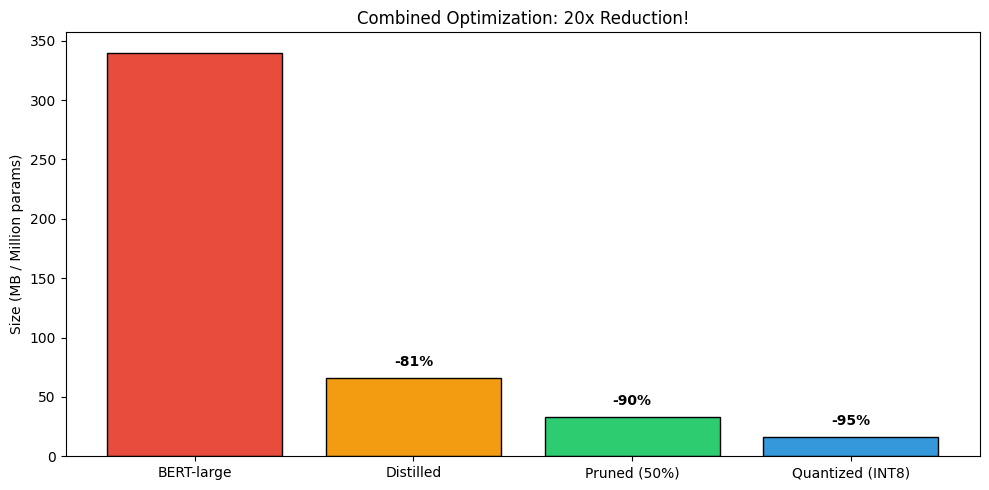

In [12]:
# Visualize combined optimization
stages = ['BERT-large', 'Distilled', 'Pruned (50%)', 'Quantized (INT8)']
sizes = [340, 66, 33, 16.5]  # Approximate sizes in millions/MB
colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(stages, sizes, color=colors, edgecolor='black')
ax.set_ylabel('Size (MB / Million params)')
ax.set_title('Combined Optimization: 20x Reduction!')

# Add reduction labels
for i, (bar, size) in enumerate(zip(bars, sizes)):
    if i > 0:
        reduction = (1 - size/sizes[0]) * 100
        ax.annotate(f'-{reduction:.0f}%', 
                   xy=(bar.get_x() + bar.get_width()/2, size + 10),
                   ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Challenge: Calculate Your Optimization Strategy

<details>
<summary><strong>💡 Click here for a Hint</strong></summary>

Consider: What techniques work **without training**? Check the Decision Matrix's 'Requires Training' column.
</details>

<details>
<summary><strong>✅ Click here for the Solution</strong></summary>

**Recommended: Quantization (INT8) + Smaller Base Model**

- **Why INT8?** No training budget eliminates Distillation/Pruning
- **Speedup:** Use DistilBERT (~2x) + INT8 quantization (~2-3x) = 4-6x total
- **Accuracy:** DistilBERT (97% of BERT) + INT8 (<1% loss) = within 3% tolerance
- **Size:** ~16MB final model (from 340MB original)
</details>

In [13]:
# Given these requirements, recommend an optimization strategy:

# Scenario:
# - Current model: BERT-large (340M params)
# - Target latency: <50ms (currently 200ms)
# - Accuracy tolerance: Can accept up to 3% accuracy drop
# - Training budget: No GPU hours available
# - Deployment target: Cloud GPU

# Questions:
# 1. Which technique(s) would you recommend?
# 2. What size reduction could you achieve?
# 3. How much speedup would you expect?

# Write your answer below:
# ...


## Key Takeaways

1. **Optimization is a Trade-off**: You balance Accuracy, Speed, and Cost (The Trilemma).
2. **Quantization** is the 'low-hanging fruit' - often giving 2-4x speedups with minimal effort and no training.
3. **Distillation** yields the best small models but requires an expensive training phase.
4. **Pruning** creates sparse models, but real-world speedups depend heavily on hardware support.
5. **Always Benchmark**: Theoretical reductions do not always translate to linear speedups.